In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import List, Tuple
from functools import cache # Python 3.9 required
from IPython.display import display
import yfinance as yf
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

TRADING_DAYS_PER_YEAR = 253

In [16]:
import os
from datetime import datetime
import concurrent
import pandas_datareader.data as web
import pandas as pd
import datetime
import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
import urllib
import urllib.request
import time
from datetime import timedelta

from ipywidgets import interactive
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frequency = "D"

w=117*8
end_date = datetime.date.today()

start_date = end_date - timedelta(weeks=w)

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

print(end_date)
print(start_date)

FRED_Indicators = ['DTB4WK','DTB3']

def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start_date, end_date)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.resample(frequency).mean().dropna()
    return(temp)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))


FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    #values.index = pd.to_datetime(FRED_set["DATE"])
    #values = values.resample(frequency).mean().dropna()
    #values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    #values = values.reset_index()

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)

etf_indexes_and_Crypto_list = ['^SP500TR']

commodities = []
for sublist in [etf_indexes_and_Crypto_list]:
    for val in sublist:
        commodities.append(val)

#pool2 = concurrent.futures.ProcessPoolExecutor(cores)

completed = []
def dl(name):
    subset = yf.download(name, start=start_date, end=end_date, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    #sleep(4)
    if len(subset) != 0:
        completed.append(name)
        return (subset)

futures2 = []

for i in commodities:
    futures2.append(dl(i))

commodities_ = pd.DataFrame()

for x in range(0,len(completed)):
    values = futures2[x]
    values.index = pd.to_datetime(values.index)
    #values = values.resample(frequency).mean().dropna()
    values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    values = values.reset_index()

    commodities_ = pd.concat([commodities_,values], axis=0)

commodities_pvt = pd.pivot_table(commodities_, values='Close', index=['Date'],columns=['Symbol'])
commodities_pvt.columns = completed
#commodities_pvt.to_csv("/mnt/distvol/commodities.csv")

def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start_date, end_date)
    temp.index = pd.to_datetime(temp.index)
    #temp = temp.resample(frequency).mean().dropna()
    return(temp)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

combined_set = pd.concat([FRED_pvt.set_index(FRED_pvt.index),commodities_pvt],axis=1)

if True:
    combined_set = combined_set.interpolate(method='linear', limit_direction='forward', axis=0)
    
    

2021-05-29
2003-06-21
[*********************100%***********************]  1 of 1 completed


,^SP500TR
2004-12-31,0.11642
2005-12-31,0.08700
2006-12-31,0.10609
2007-12-31,0.14816
2008-12-31,-0.15755
2009-12-31,-0.20105
2010-12-31,0.22730
2011-12-31,0.13395
2012-12-31,0.11270
2013-12-31,0.21881


In [136]:
TREASURY_BILL_RATE =  combined_set['DTB3'].values[-1]
beatSP500 = pd.DataFrame(combined_set['^SP500TR']).resample('Y').mean().pct_change().dropna().values[-1]
#combined_set['^SP500TR'].pct_change[-1]
#%, Jan 2021
#FRED_pvt


0.02

In [19]:
# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations

In [20]:
def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets))
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'

In [103]:
def yf_retrieve_data(tickers: List[str],p):
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(period=p,auto_adjust=True)

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes

In [62]:
import pandas_market_calendars as mcal
import os.path
from os import path
import stat
import re

def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

one_week_end = start_date
one_week_start = one_week_end - timedelta(weeks=1)

#need to do the two pass trick (i.e. find stocks fully populated a week 9 quarters back)

nyse = mcal.get_calendar('NYSE')
official_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date)

date_time_obj_start = start_date

date_time_obj_end = end_date

one_week_trading_dates = nyse.schedule(start_date=one_week_start, end_date=one_week_end)

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

#should turn this into a function
if path.exists("nasdaqtraded.txt"):
    print("file exists")
    
    filePath = 'nasdaqtraded.txt'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading")
        urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
        urllib.request.urlretrieve(url, 'mfundslist.txt')
        urllib.request.urlretrieve(url, 'bonds.txt')
    else:
      print("equal dates, not redownloading")
    
else:
    print("downloading nasdaqtraded.txt")
    urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
    urllib.request.urlretrieve(url, 'mfundslist.txt')
    urllib.request.urlretrieve(url, 'bonds.txt')
    
df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#process symbols for bad characters
BAD_CHARS = ['$','.']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df1 = df1[~df1['Symbol'].str.contains(pat)]
df2 = df2[~df2['Symbol'].str.contains(pat)]
df3 = df3[~df3['Symbol'].str.contains(pat)]


file exists
Last Modified Time :  Sat May 29 10:08:12 2021
equal dates, not redownloading


/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [ ]:

#choose size
size=100
#stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(df1["Symbol"].sample(n=int(size)))
mfunds = list(df2["Symbol"].sample(n=int(size/3)))
bonds = list(df3["Symbol"].sample(n=int(size/3)))
#symbols = unique(stocks + mfunds + bonds)
symbols = unique(stocks)


In [68]:

def dl_one_week(stock):
    subset = yf.download(stock, start=one_week_start, end=one_week_end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[one_week_start.strftime('%Y-%m-%d'):one_week_end.strftime('%Y-%m-%d')]
    if len(subset) != 0:
        return (subset)

def processStocks(symbols):

    futures1 = [pool1.submit(dl_one_week, args) for args in symbols]
    wait(futures1, timeout=None, return_when=ALL_COMPLETED)

    symbols_data_one_week = pd.DataFrame()

    for x in range(0,len(symbols)):
        prices = pd.DataFrame(futures1[x].result())
        prices['Symbol'] = symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        symbols_data_one_week = pd.concat([symbols_data_one_week,prices])

    #symbols_data_one_week

    #stocks that existed 9 quarters ago
    vetted_symbols = list(symbols_data_one_week.Symbol.unique())

    return(vetted_symbols)

stocks = []

if path.exists('symbols_data.csv'):
    print("data exists")
    
    filePath = 'symbols_data.csv'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading stocks")
        
        stocks = processStocks(symbols)
        
    else:
        print("equal dates, not redownloading")
    
else:
    print("downloading symbols")
    stocks = processStocks(symbols)

data exists
Last Modified Time :  Fri May 28 20:36:09 2021
not same dates downloading stocks


In [115]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

sp500 = first_table
symbols_sp500 = sp500['Symbol'].values.tolist()


payload=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100#Components')
table = payload[3]

ns100 = table
symbols_ns100 = ns100['Ticker'].values.tolist()


payload=pd.read_html('https://en.wikipedia.org/wiki/S%26P_500_Dividend_Aristocrats#Index')
dividendAristocraft = payload[2]['Ticker symbol']

payload=pd.read_html('https://finance.yahoo.com/quote/SPY/holdings/')
#dividendAristocraft = payload[2]['Ticker symbol']

top10 = payload[0]['Symbol']


In [127]:
stocks

0     AAPL
1     MSFT
2     AMZN
3       FB
4    GOOGL
5     GOOG
6     TSLA
7    BRK.B
8      JPM
9      JNJ
Name: Symbol, dtype: object

In [130]:
stocks = top10

#BAD_CHARS = ['$','.']
#pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

cleaned = []
for i in range(0,len(stocks)):
    print(i)
    cleaned.append(stocks[i].replace('.','-'))
    
cleaned

0
1
2
3
4
5
6
7
8
9


['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B', 'JPM', 'JNJ']

[0.25185623]


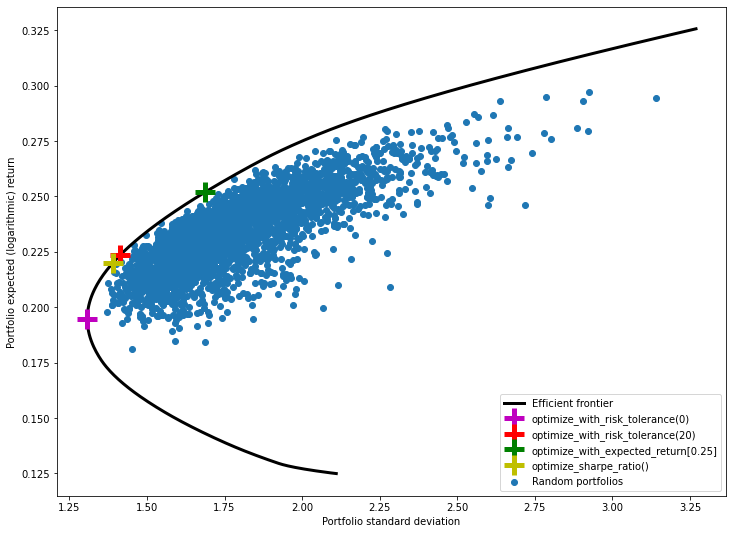

In [144]:

p = '10y'
r = beatSP500
#print(r)
daily_dataframes = yf_retrieve_data(cleaned, p)
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

X = []
y = []

# Drawing random portfolios
for i in range(3000):
  portfolio = Portfolio(assets)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
  portfolio.unsafe_optimize_with_risk_tolerance(rt)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(r)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return' + str(np.round(r,2)))

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()

In [143]:
pd.options.display.float_format = "{:,.5f}".format

portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(r)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(20)',
      'optimize_with_expected_return' + str(np.round(r,2)),
      'optimize_sharpe_ratio()',
    ],
  ).sort_values(by=['optimize_sharpe_ratio()'],ascending=False)
)

,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(20),optimize_with_expected_return[0.25],optimize_sharpe_ratio()
9,JNJ,0.22320,0.12799,0.03451,0.13945
1,MSFT,0.10121,0.13610,0.17036,0.13182
5,GOOG,0.10071,0.11717,0.13334,0.11510
4,GOOGL,0.10106,0.11596,0.13054,0.11405
7,BRK.B,0.16941,0.10582,0.04333,0.11347
0,AAPL,0.08191,0.10697,0.13161,0.10396
2,AMZN,0.06909,0.10406,0.13839,0.09996
8,JPM,0.08166,0.06618,0.05095,0.06831
3,FB,0.04981,0.06292,0.07584,0.06136
6,TSLA,0.02194,0.05684,0.09114,0.05252
